### Objectives

1. Learn to build a deep neural network in PyTorch (`nn.Module`)
2. Learn to train the model (on training data) and evaluate it (on test data)
3. Learn about several numerical problems in deep learning:
    - exploding / vanishing gradient (stops learning)
    - slow learning

### Section 1: Load and explore the data

In [2]:
import pandas as pd

df_train = pd.read_csv("./data/Training set.csv")
df_test = pd.read_csv("./data/Test set.csv")

In [3]:
df_train.head()

,Height,Weight,Sex
0,165.65,35.41,Female
1,148.53,74.45,Female
2,167.04,81.22,Male
3,161.54,71.47,Male
4,174.31,78.18,Male


In [94]:
df_train.sample(n=5)

,Height,Weight,Sex
1494,174.31,64.81,1
1995,160.18,54.73,1
1209,178.04,67.51,1
796,170.74,73.57,1
515,179.55,65.47,1


In [4]:
df_train.describe()

,Height,Weight
count,3000.000000,3000.000000
mean,161.350427,68.400610
std,54.912719,17.041528
min,25.680000,8.530000
25%,149.502500,57.937500
50%,160.870000,67.370000
75%,171.632500,77.952500
max,3050.000000,485.000000


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Height  3000 non-null   float64
 1   Weight  3000 non-null   float64
 2   Sex     3000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 70.4+ KB


### Remove Outliers

A common way to remove outliers is to use **z-scores**. Outliers are values that have z-scores that are greater than 3 or less than -3.

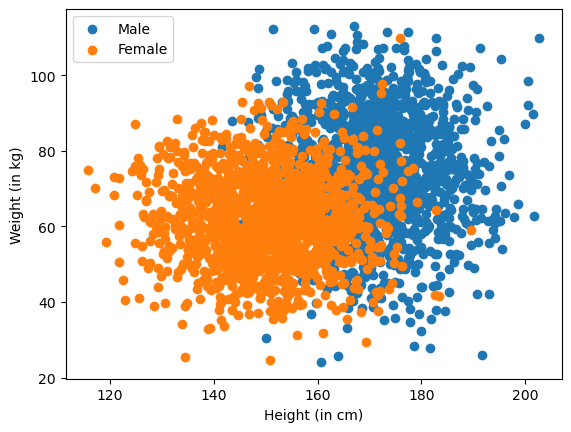

In [11]:
import matplotlib.pyplot as plt

male = df_train[df_train['Sex'] == 1]
female = df_train[df_train['Sex'] == 0]
plt.scatter(male['Height'], male['Weight'], label="Male")
plt.scatter(female['Height'], female['Weight'], label="Female")
plt.legend(["Male", "Female"])
plt.xlabel("Height (in cm)")
plt.ylabel("Weight (in kg)")
plt.show()

In [9]:
import numpy as np

z_threshold = 3
# do it twice
for i in range(2):
    for col in ['Height', 'Weight']:
        data = df_train[col].values
        # Calculate z-scores
        z = (data - np.mean(data)) / np.std(data)
        # Flag outliers    
        outlier_flags = np.abs(z) > z_threshold
        # Filter outliers from dataframe      
        df_train = df_train[outlier_flags == False]


In [10]:
df_train.describe()

,Height,Weight
count,2985.000000,2985.000000
mean,160.467668,68.194804
std,14.899290,15.027508
min,115.940000,24.140000
25%,149.520000,57.940000
50%,160.860000,67.310000
75%,171.620000,77.790000
max,202.670000,113.090000


### Encode `str` categories as `int`s

In [ ]:
df_train.loc[df_train['Sex'] == 'Male',  'Sex'] = 1
df_train.loc[df_train['Sex'] == 'Female','Sex'] = 0
df_test.loc[df_test['Sex']   == 'Male',  'Sex'] = 1
df_test.loc[df_test['Sex']   == 'Female','Sex'] = 0

# also make a dictionary mapping from category number to name (and reverse)
i_to_sex = {1: 'Male', 0: 'Female'}
sex_to_i = {'Male': 1, 'Female': 0}

### Plot the data

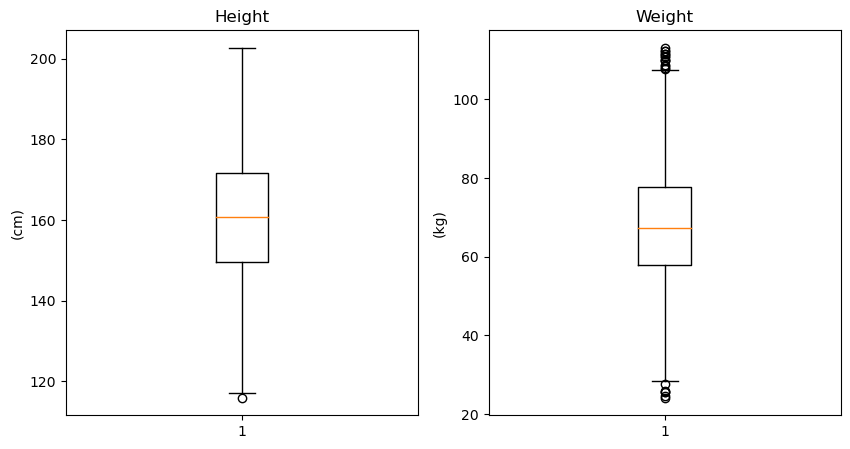

In [13]:
# Define data and labels
height_data = df_train['Height'].dropna().values
weight_data = df_train['Weight'].dropna().values

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create boxplots for height and weight
ax1.boxplot(height_data)
ax1.set_title('Height')
ax1.set_ylabel('(cm)')

ax2.boxplot(weight_data)
ax2.set_title('Weight')
ax2.set_ylabel('(kg)')

# Display the plot
plt.show()

In [42]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

class NeuralNetwork(nn.Module):

    def __init__(self, n_input, n_hidden, n_output):
        super().__init__()

        self.linear1 = nn.Linear(n_input, n_hidden)
        self.relu1 = nn.LeakyReLU(inplace=True)
        self.linear2 = nn.Linear(n_hidden, n_output)

        # weights
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        # biases
        nn.init.constant_(self.linear1.bias, 0)
        nn.init.constant_(self.linear2.bias, 0)


    def forward(self, x):
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        return x

In [71]:
# Create the model
model = NeuralNetwork(2, 3, 1)
# Loss Function: Binary Classification Error with Logits (logits are pre-activation values of the output)
loss_fn = nn.BCEWithLogitsLoss()
# Minimization algorithm
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [81]:
# Define the input and output data
train_inputs = torch.tensor(df_train[["Height", "Weight"]].values, dtype=torch.float32)
train_outputs = torch.tensor(df_train["Sex"].astype(int).values, dtype=torch.float32).view(-1, 1)
# normalize input data (better for learning)
train_inputs_norm = (train_inputs - torch.mean(train_inputs, dim=0)) / torch.std(train_inputs, dim=0)

test_inputs = torch.tensor(df_test[["Height", "Weight"]].values, dtype=torch.float32)
test_outputs = torch.tensor(df_test["Sex"].astype(int).values, dtype=torch.float32).view(-1, 1)
# normalize input data (better for learning)
test_inputs_norm = (test_inputs - torch.mean(test_inputs, dim=0)) / torch.std(test_inputs, dim=0)

In [96]:
print('train_input:', train_inputs_norm.shape, train_inputs_norm.type())
print(train_inputs_norm[:5])
print('')
print('train_output:', train_outputs.shape, train_outputs.type())
print(train_outputs[:5])

train_input: torch.Size([2985, 2]) torch.FloatTensor
tensor([[ 0.3478, -2.1817],
        [-0.8012,  0.4162],
        [ 0.4411,  0.8668],
        [ 0.0720,  0.2179],
        [ 0.9291,  0.6645]])

train_output: torch.Size([2985, 1]) torch.FloatTensor
tensor([[0.],
        [0.],
        [1.],
        [1.],
        [1.]])


In [79]:
train_losses = []
epochs = []

### Training Loop

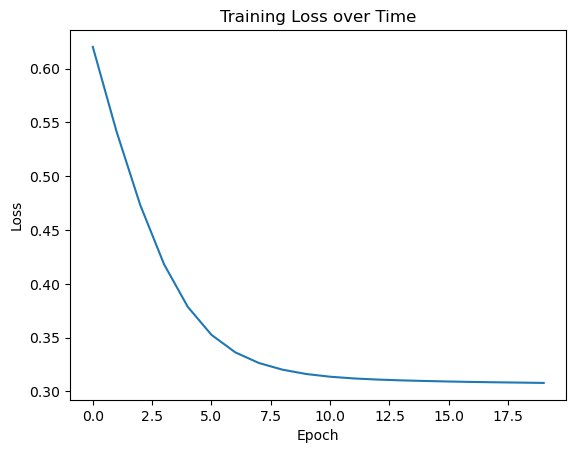

In [85]:
num_epochs = 1000 # determines how many times to pass the entire dataset to the model

for epoch in range(num_epochs):

    # Step 1. Forward pass: compute predicted y by passing x to the model.
    output = model(train_inputs_norm)

    # Step 2. Calculate the loss
    loss = loss_fn(output, train_outputs)

    # Step 3. Backward pass: compute gradient of the loss with respect to model parameters
    # But, first, reset the gradients from the previous loop iteration
    optimizer.zero_grad()
    loss.backward()

    # Step 4. Update the weights
    optimizer.step()

    # Record loss and epoch values (used for plot)
    if (epoch + 1) % 100 == 0:
        train_losses.append(loss.item())
        epochs.append(epoch)

plt.plot(np.arange(len(epochs)), train_losses)
plt.title('Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Evaluate the model on the test set

In [86]:
threshold = 0.5
model.eval() # see: https://cs230.stanford.edu/blog/pytorch/#training-vs-evaluation
with torch.no_grad():
    pred = model(test_inputs_norm)
    pred = (pred > threshold).float()

# TP + TN / (TP + TN + FP + FN)
accuracy = torch.sum(pred == test_outputs) / len(test_outputs)

# True Positives (TP): correctly predicted as positive
TP = ((pred == 1) & (test_outputs == 1)).sum().item()

# False Positives (FP): incorrectly predicted as positive
FP = ((pred == 1) & (test_outputs == 0)).sum().item()

# False Negatives (FN): incorrectly predicted as negative
FN = ((pred == 0) & (test_outputs == 1)).sum().item()

precision = TP / (TP + FP)
recall = TP / (TP + FN)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1 Score:  {f1:.3f}")

Accuracy:  86.83%
Precision: 90.72%
Recall:    83.02%
F1 Score:  0.867
